## MaskContours-Misclassification

MaskContours-Testing discovered a few remaining issues, one of which looks like a systematic misclassification of digits where digit N is misclassified as digit N - 1. The working theory is that the atlas template match is *just* to the left of the intended digit's column. If this is the case, should be an easy fix.

In [2]:
mask_dir = r'E:\Ultimate\day1_streams\masks'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
ultimate_root = r'C:/users/phyto/Desktop/ultimate'
model_file = 'model.pkl'

model_path = os.path.join(ultimate_root, model_file)

In [4]:
test_image_path = os.path.join(ultimate_root, 'masks/102_58.1.png')
image_mask_dir = os.path.join(ultimate_root, 'masks')

In [5]:
def extract_blobs(binary_image):
    connectivity = 4
    output = cv2.connectedComponentsWithStats(binary_image, connectivity, cv2.CV_8S)
    
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    blobs = []
    xcoords = []
    for label in range(num_labels):
        stats_indices = [cv2.CC_STAT_LEFT, cv2.CC_STAT_WIDTH, cv2.CC_STAT_TOP, cv2.CC_STAT_HEIGHT]
        xmin, width, ymin, height = [stats[label][i] for i in stats_indices]
        
        xmax = xmin + width
        ymax = ymin + height

        blob = np.where(labels[ymin:ymax, xmin:xmax] == label, 255, 0).astype('uint8')
        blobs.append(blob)
        xcoords.append(xmin)
        
    return blobs, xcoords

In [6]:
# Make an atlas from the digits that I have at this directory
digits_dir = os.path.join(ultimate_root, 'digits')
digits_index = [[] for _ in range(10)]
stats_array = []

for d in os.listdir(digits_dir):
    full_root = os.path.join(digits_dir, d)
    
    for f in os.listdir(full_root):
        full_path = os.path.join(full_root, f)
        
        i = int(d)
        img = cv2.imread(full_path)
        binary_image = cv2.inRange(img, (40, 40, 40), (255, 255, 255))
        digits_index[i].append(binary_image)
        
        stats_array.append(digits_index[i][-1].shape[:2])
        
for i in range(10):
    print("{} : {}".format(i, len(digits_index[i])))

0 : 50
1 : 73
2 : 47
3 : 35
4 : 58
5 : 45
6 : 51
7 : 35
8 : 45
9 : 51


In [7]:
cell_dim = 32
#min_rows = np.min(np.array([len(digits_index[i]) for i in range(10)]))
min_rows = 10
print("Min rows = {}".format(min_rows))
atlas_height = min_rows * cell_dim
atlas_width  = cell_dim * 10

atlas = np.zeros((atlas_height, atlas_width)).astype('uint8')

for digit in range(10):
    np.random.shuffle(digits_index[digit])
    for i, img in enumerate(digits_index[digit][:min_rows]):
        xmin, ymin = digit * cell_dim, i * cell_dim
        xmax, ymax = xmin + cell_dim, ymin + cell_dim
        
        cell_img = cv2.resize(img, (cell_dim, cell_dim))
        atlas[ymin:ymax, xmin:xmax] = cell_img
        
cv2.imwrite(r'C:\users\phyto\desktop\atlas2.png', atlas)

Min rows = 10


True

In [8]:
gt_directories = [
    os.path.join(ultimate_root, 'corpus_2'),
    os.path.join(ultimate_root, 'corpus_3'), 
    os.path.join(ultimate_root, 'corpus_4'), 
    os.path.join(ultimate_root, 'corpus_5'),
    os.path.join(ultimate_root, 'corpus_6'),
    os.path.join(ultimate_root, 'corpus_7')
]

def get_regions_from_path(img_path):
    # We're assuming the GT annotations file is right alongside 
    # this image.
    
    regions = []
    annotations_path = img_path.replace(".png", ".xml")
    if not os.path.exists(annotations_path):
        return regions
    
    with open(annotations_path, 'r') as fr:
        tree = ET.parse(fr)
        root = tree.getroot()
        
        objects = root.findall('object')
        if objects is None or len(objects) == 0:
            return regions
        else:
            img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            for obj in objects:
                cls = obj.find('name').text
                if ':' in cls:
                    continue
                
                xmlbox = obj.find('bndbox')
                
                xmin, xmax = int(xmlbox.find('xmin').text), int(xmlbox.find('xmax').text)
                ymin, ymax = int(xmlbox.find('ymin').text), int(xmlbox.find('ymax').text)
                
                regions.append((img_rgb[ymin:ymax, xmin:xmax], cls))
                
    return regions

In [9]:
images = []
gtvalues = []
for gt_dir in gt_directories:
    print(gt_dir)
    for filename in [f for f in os.listdir(gt_dir) if f[-4:].lower() == ".png"]:
        full_path = os.path.join(gt_dir, filename)
        
        regions = get_regions_from_path(full_path)
        images.extend([r[0] for r in regions])
        gtvalues.extend([r[1] for r in regions])

C:/users/phyto/Desktop/ultimate\corpus_2
C:/users/phyto/Desktop/ultimate\corpus_3
C:/users/phyto/Desktop/ultimate\corpus_4
C:/users/phyto/Desktop/ultimate\corpus_5
C:/users/phyto/Desktop/ultimate\corpus_6
C:/users/phyto/Desktop/ultimate\corpus_7


In [10]:
digits_path = os.path.join(ultimate_root, 'digits')
#nondigits_path = r'C:\Users\phyto\Desktop\ultimate\nondigits'

def get_image_stats(path):
    all_stats = []
    for root, _, files in os.walk(path):
        for f in files:
            if f[-4:] == ".png":
                full_path = os.path.join(root, f)
                im = cv2.cvtColor(cv2.imread(full_path), cv2.COLOR_BGR2GRAY)

                stats = (im.shape[1], im.shape[0], cv2.countNonZero(im), os.path.basename(root))

                all_stats.append(stats)
                
    return all_stats

digits_stats = get_image_stats(digits_path)
#nondigits_stats = get_image_stats(nondigits_path)

In [11]:
def img_area(im):
    return im.shape[0] * im.shape[1]

def prefilter_blobs(imgshape, blobs, xcoords, model_path):
    do_plots = False
    if os.path.exists(model_path):
        with open(model_path, 'rb') as fr:
            gmm = pickle.load(fr)
        
        # X = np.vstack([stats['digitw'], stats['digith']]).transpose()
        features = np.vstack([[b.shape[1] / imgshape[1] for b in blobs], [b.shape[0] / imgshape[0] for b in blobs]]).transpose()
        scores = np.array(gmm.score_samples(features))
        
        indices = np.where(scores > -1)
        complement = np.where(scores <= -1)
        rejected = []
        if len(indices) > 0:
            if len(complement[0]) > 0:
                rejected = [blobs[i] for i in complement[0]]
            
            blobs = [blobs[i] for i in indices[0]]
            xcoords = [xcoords[i] for i in indices[0]]
        else:
            blobs = []
            rejected = blobs
            xcoords = xcoords
        
    if do_plots:
        rejected = sorted(rejected, reverse=True, key=lambda x: x.shape[0] * x.shape[1])[:min(10, len(rejected))]
        _, ax = plt.subplots(1, len(rejected))
        if len(rejected) == 1:
            ax.imshow(rejected[0])
        else:
            for i, a in enumerate(ax):
                a.imshow(rejected[i])

        plt.show()
        plt.close('all')
    
    return blobs, xcoords
    
def filter_results(blobs_to_filter):
    blobs_by_area = sorted(blobs_to_filter, key = lambda x: img_area(x[0]), reverse=True)
    largest = blobs_by_area[0]
    
    #print([(blob[0].shape[0] / largest[0].shape[0]) for blob in blobs_by_area])
    
    large_blobs = [('big', blob) for blob in blobs_by_area if (blob[0].shape[0] / largest[0].shape[0]) > 0.87]
    large_blobs.extend([('small', blob) for blob in blobs_by_area if (blob[0].shape[0] / largest[0].shape[0]) <= 0.445 and (blob[0].shape[0] / largest[0].shape[0]) >= 0.355])
    
    return sorted(large_blobs, key = lambda x: x[1][2]), [(blob[0].shape[0] / largest[0].shape[0]) for blob in blobs_by_area]

def position_digits(blobs, gtvalue):
    blob_positions = [-1] * 4
    
    big_blobs = [blob[1] for blob in blobs if blob[0] == 'big']
    if len(big_blobs) == 0:
        return blob_positions
    elif len(big_blobs) > 3:
        big_blobs = big_blobs[-3:]
    
    small_blobs = [blob[1] for blob in blobs if blob[0] == 'small']
    if len(small_blobs) > 0:
        blob_positions[3] = small_blobs[0][1]
        
    for i, b in enumerate(reversed(big_blobs)):
        target_index = 2 - i
        blob_positions[target_index] = b[1]

    gt_positions = [-1] * 4
    for i, d in enumerate(reversed(gtvalue.replace('.', ''))):
        index = 3 - i
        gt_positions[index] = int(d)
            
    return blob_positions, gt_positions

def confusion_results(blob_positions, gt_positions, confusion_matrix = None):
    if confusion_matrix is None:
        confusion_matrix = np.zeros((10, 10))
        
    for i in range(len(gt_positions)):
        c_i, c_j = gt_positions[i], blob_positions[i]
        
        if c_i >= 0 and c_j >= 0:
            confusion_matrix[c_j, c_i] += 1
            
    return confusion_matrix

def missing_results(blob_positions, gt_positions):
    pass

def is_bad(blob_positions, gt_positions):
    #
    # Just check the 'big' digits
    #
    zipped = zip(blob_positions[:3], gt_positions[:3])
    
    # Uncomment this line to check accuracy disregarding the leading digit
    #zipped = zip(blob_positions[1:3], gt_positions[1:3])
    return not all([i == j for (i, j) in zipped])

In [31]:
atlas_copy = atlas.copy()

blobextract_times = []
template_times = []
regionproc_times = []

def get_blobs(images):
    good_regions = []
    bad_regions = []
    confusion_matrix = np.zeros((10, 10))
    for j, image in enumerate(images):
        gtvalue = gtvalues[j]
        
        btime = time.time()
        
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        #img_inrange = cv2.inRange(hsv_image, (0, 0, 0), (180, 255, 80))
        img_inrange = cv2.inRange(hsv_image, (0, 0, 0), (180, 255, 120))
        img_inverted = cv2.bitwise_not(img_inrange)

        blobs, xcoords = extract_blobs(img_inverted)
        blobs_to_render = []
        rejected_blobs = []
        scores = []# [(blob[0].shape[0] / largest[0].shape[0]) for blob in sorted(blobs, key=lambda x : img_area(x))]

        blobextract_times.append(time.time() - btime)
        
        blobs, xcoords = prefilter_blobs(hsv_image.shape, blobs, xcoords, model_path)
        
        for i, blob in enumerate(blobs):
            if np.sum(blob) < 3000:
                rejected_blobs.append((blob, -1.0))
                continue

            ttime = time.time()
            blob_cell = cv2.resize(blob, (cell_dim, cell_dim))
            response = cv2.matchTemplate(blob_cell, atlas, cv2.TM_CCORR_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(response)
            template_times.append(time.time() - ttime)

            if max_val > 0.92:
                digit = int(max_loc[0] + cell_dim / 2) // cell_dim

                #if digit == 0:
                #    cv2.circle(atlas_copy, max_loc + cell_dim / 2, 5, (0, 255, 0))
                #if digit == 1:
                #    cv2.circle(atlas_copy, max_loc, 5, (255, 0, 0))
                blobs_to_render.append((blob, digit, xcoords[i], max_val))
            else:
                rejected_blobs.append((blob, max_val))


        if len(blobs_to_render) == 0:
            bad_regions.append((image, blobs_to_render, None, None, gtvalue, rejected_blobs))
            continue
        
        blobs_to_render, _ = filter_results(blobs_to_render)
        bs, gs = position_digits(blobs_to_render, gtvalue)
        confusion_matrix = confusion_results(bs, gs, confusion_matrix)

        if is_bad(bs, gs):
            bad_regions.append((image, blobs_to_render, gs, bs, gtvalue, rejected_blobs, scores))
        else:
            good_regions.append((image, blobs_to_render, gs, bs, gtvalue, rejected_blobs, scores))
            
        regionproc_times.append(time.time() - btime)
            
    return good_regions, bad_regions, confusion_matrix
    
def render_regions(regiondata):
    for r in regiondata:
        #score = compute_gt_score(blobs_to_render, )
        blobs_to_render = r[1]
        image           = r[0]
        gtvalue         = r[4]
        #rejected_blobs  = r[5]
        rejected_blobs  = [] # disable for now
        scores          = [] if len(r) < 7 else r[6]

        if len(blobs_to_render) < 1:
            plt.imshow(image)
            continue

        print(scores)
        _, ax = plt.subplots(1, len(blobs_to_render) + 1, figsize=(20, 10))
        ax[0].imshow(image)
        ax[0].set_title("GT value = {}".format(gtvalue))

        widths = []
        heights = []

        for i in range(1, len(blobs_to_render) + 1):
            digit = blobs_to_render[i - 1][1][1]
            blob  = blobs_to_render[i - 1][1][0]
            max_val = blobs_to_render[i - 1][1][3]

            widths.append(blob.shape[1])
            heights.append(blob.shape[0])

            ax[i].set_title("Classified as: {} ({:2f})".format(digit, max_val))
            ax[i].imshow(blob)
        
        _, ax = plt.subplots(1, len(rejected_blobs), figsize=(20, 10))
        for i, rb in enumerate(rejected_blobs):
            blob = rb[0]
            score = rb[1]
            
            ax[i].imshow(blob)
            ax[i].set_title("Score = {}".format(score))

        plt.show()
        plt.close('all')

In [13]:
processed_images = []
N = 32
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #quantized = np.floor(gray*(N/255)*(255/N)).astype('uint8')
    canny = cv2.Canny(gray, 80, 210) 
    
    #kernel = np.ones((2,2),np.uint8)
    #canny = dilation = cv2.dilate(canny,kernel,iterations = 1)
    
    new_image = image.copy()
    new_image[np.where(canny > 0)] = (0, 0, 0)
    processed_images.append(new_image) 

In [32]:
#good_regions, bad_regions, confusion_matrix = get_blobs(images)
good_regions, bad_regions, confusion_matrix = get_blobs(processed_images)

In [15]:
confusion_matrix

array([[283.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 417.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0., 188.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 172.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   1.,   0., 183.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 141.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 124.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 166.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 162.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 114.]])

In [16]:
#
# Get and plot some blob stats
#
stats = { 'digitw' : [], 'digith' : [], 'nondigitw' : [], 'nondigith' : [], 'digitar' : [] }

#good_regions.append((image, blobs_to_render, gs, bs, gtvalue, rejected_blobs, scores))
#                blobs_to_render.append((blob, digit, xcoords[i], max_val))

for gr in good_regions:
    image = gr[0]
    h, w = image.shape[:2]
    
    accepted = gr[1]
    for a in accepted:
        blob = a[1]
        bh, bw = blob[0].shape[:2]
        
        stats['digith'].append(bh / h)
        stats['digitw'].append(bw / w)
        stats['digitar'].append(cv2.countNonZero(blob[0]) / (bh * bw))
    
    rejected = gr[5]
    for r in rejected:
        blob = r[0]
        bh, bw = blob.shape[:2]
        
        stats['nondigith'].append(bh / h)
        stats['nondigitw'].append(bw / w)

C:\Users\phyto\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'digitar')

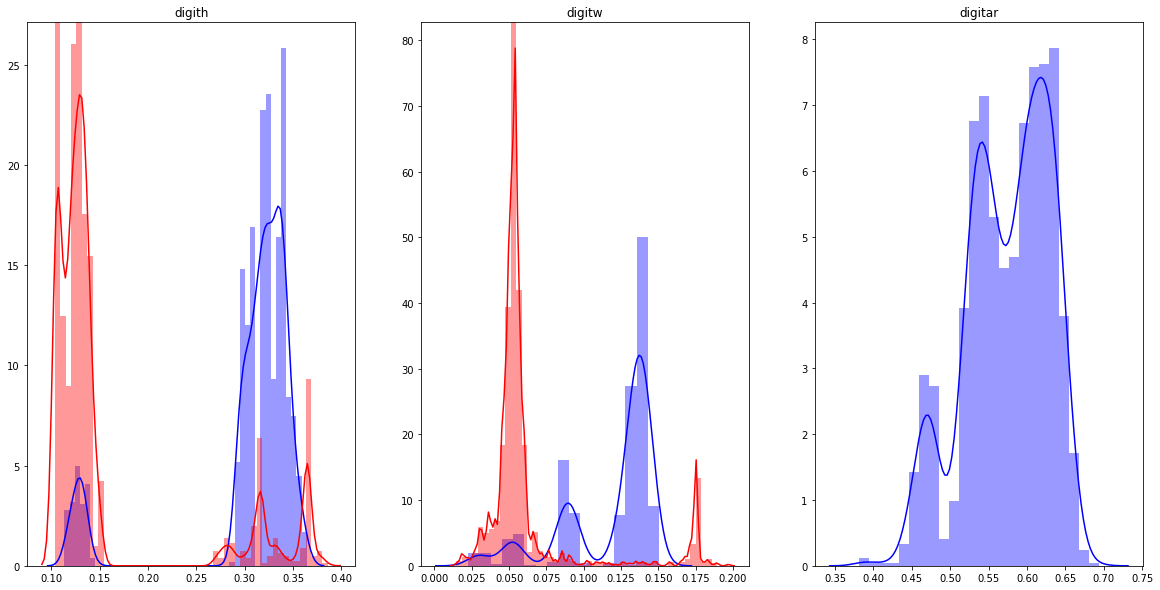

In [17]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.distplot(stats['digith'], ax=ax[0], color='b')
sns.distplot(stats['nondigith'], ax=ax[0], color='r')
ax[0].set_title('digith')

sns.distplot(stats['digitw'], ax=ax[1], color='b')
sns.distplot(stats['nondigitw'], ax=ax[1], color='r')
ax[1].set_title('digitw')

sns.distplot(stats['digitar'], ax=ax[2], color='b')
ax[2].set_title('digitar')

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, ax, label=True):
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax, alpha=w * w_factor * 2)

(1887, 2)


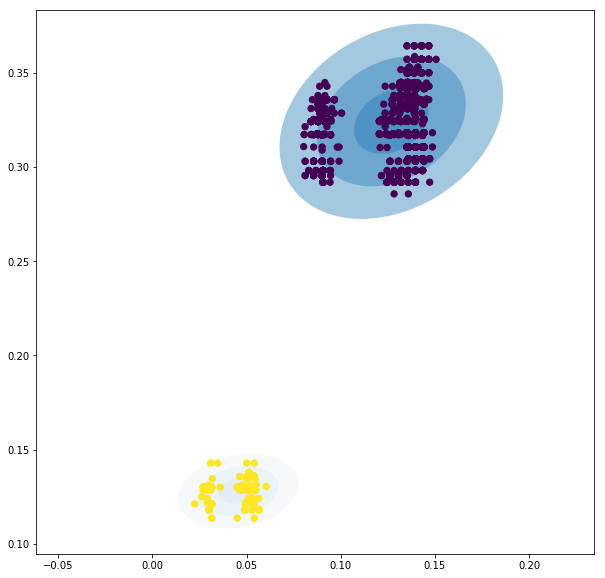

In [19]:
X = np.vstack([stats['digitw'], stats['digith']]).transpose()
print(X.shape)
gmm = GaussianMixture(n_components = 2, n_init=1000, covariance_type='full').fit(X)

#stats = { 'digitw' : [], 'digith' : [], 'nondigitw' : [], 'nondigith' : [], 'digitar' : [] }
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(stats['nondigitw'], stats['nondigith'], c='r')
#ax.scatter(stats['digitw'], stats['digith'], c='b')
plot_gmm(gmm, X, ax)

In [20]:
# Okay... so now we see how it does rejecting blobs
bad = []
good = []
for br in bad_regions:
    image = br[0]
    h, w = image.shape[:2]
    
    accepted = br[1]
    for a in accepted:
        blob = a[1]
        bh, bw = blob[0].shape[:2]
        
        digith = (bh / h)
        digitw = (bw / w)
        #stats['digitar'].append(cv2.countNonZero(blob[0]) / (bh * bw))
        
        #print(gmm.score_samples([[digitw, digith]]))
        #print(gmm.score_samples([[0, 0]]))
        if gmm.score_samples([[digitw, digith]]) < 0:
            bad.append([digitw, digith])
        else:
            good.append([digitw, digith])
    
    rejected = br[5]
    for r in rejected:
        blob = r[0]
        bh, bw = blob.shape[:2]
        
        nondigith = (bh / h)
        nondigitw = (bw / w)

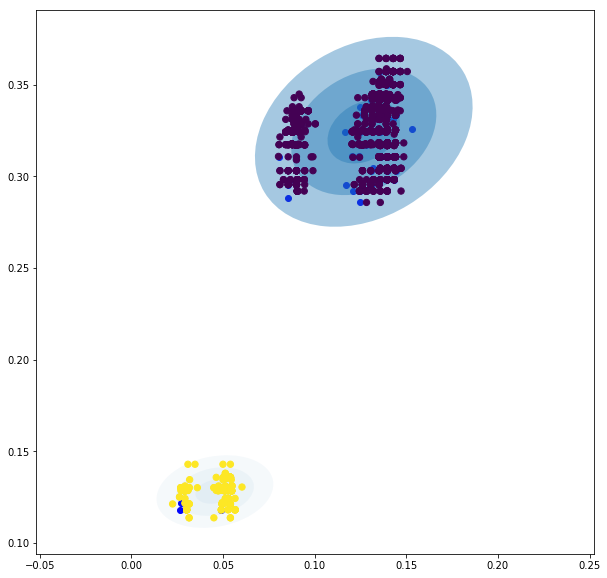

In [21]:
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(stats['nondigitw'], stats['nondigith'], c='r')
#ax.scatter(stats['digitw'], stats['digith'], c='b')
plot_gmm(gmm, X, ax)
ax.scatter([b[0] for b in bad], [b[1] for b in bad], c='r')
ax.scatter([g[0] for g in good], [g[1] for g in good], c='b')

In [22]:
#plt.imshow(atlas_copy)

In [23]:
with open(model_path, 'wb') as fw:
    pickle.dump(gmm, fw)

In [24]:
# 519; 41 @ 110
# 522; 38 @ 120
# 520, 40 @ 125
# 518; 42 @ 130
# 515; 45 @ 140
print(len(good_regions))
print(len(bad_regions))
print(len(good_regions) / (len(good_regions) + len(bad_regions)))

# with and w/o oquantized, + dilation: 523; 37, 0.91 thresh
# no quantization, no dilation: 523, 37, 0.91 thresh
# no quantization, no dilation: 528, 32, 0.92 thresh

830
66
0.9263392857142857


In [25]:
#render_regions(good_regions)

In [26]:
#render_regions(bad_regions)

C:\Users\phyto\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


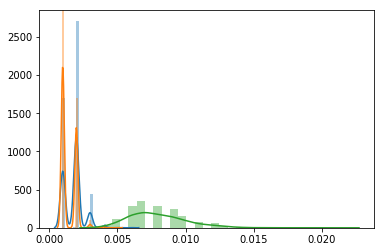

In [34]:
sns.distplot(blobextract_times)
sns.distplot(template_times)
sns.distplot(regionproc_times)

In [29]:
np.max(blobextract_times)

0.004990816116333008

In [30]:
np.max(template_times)

0.003015756607055664

In [35]:
np.max(regionproc_times)

0.020985841751098633

In [27]:
dump_dir = r'C:\Users\phyto\Desktop\temp\thresholding_experiment'

for i, r in enumerate(bad_regions):
    image = cv2.cvtColor(r[0], cv2.COLOR_BGR2RGB)
    
    full_path = os.path.join(dump_dir, str(i) + '.png')
    # disable for now
    cv2.imwrite(full_path, image)